In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn import metrics
import nltk 
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [4]:
#Load csv file
file_name=input("Enter .csv file name with Amazon product reviews to open: ")
df=pd.read_csv(file_name)
df.head()

Enter .csv file name with Amazon product reviews to open: oculusrift.csv


,Rating,Title,Date,Verified Purchase,Body,Helpful Votes
0,Rating,Title,Date,Verified Purchase,Body,Helpful Votes
1,3.0,Worth experiencing but I am looking forward to...,"January 10, 2018",Yes,I’ve had my Oculus Rift for about a year now a...,5
2,4.0,"Amazing experience, hard to complain about any...","July 2, 2017",Yes,It's hard not to be impressed with these VR un...,3
3,3.0,"I thoroughly enjoy this system, and use it at ...","April 1, 2017",Yes,‎ One thing they don't mention is if you do n...,36
4,3.0,An UP and DOWN experience so far.,"March 7, 2018",Yes,I originally wrote a horrible review for this ...,1


In [6]:
#Data exploration
df['Rating'] = df['Rating'].convert_objects(convert_numeric=True) #convert rating column to float value
print ("Summary statistics of ratings: \n",df.describe())
print ("\nTotal number of reviews:",len(df))
print("\nPercentage of reviews with neutral sentiment : {:.2f}%".format(df[df['Rating']==3]['Title'].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%".format(df[df['Rating']>3]['Title'].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%".format(df[df['Rating']<3]['Title'].count()/len(df)*100))

Summary statistics of ratings: 
            Rating
count  100.000000
mean     4.310000
std      1.031768
min      1.000000
25%      4.000000
50%      5.000000
75%      5.000000
max      5.000000

Total number of reviews: 101

Percentage of reviews with neutral sentiment : 8.91%

Percentage of reviews with positive sentiment : 83.17%

Percentage of reviews with negative sentiment : 6.93%


/Users/tanvirniaz/Documents/Python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


Text(0,0.5,'Count')

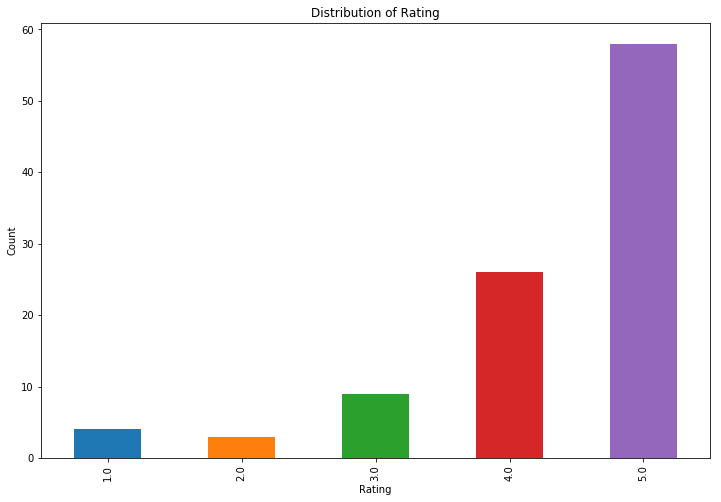

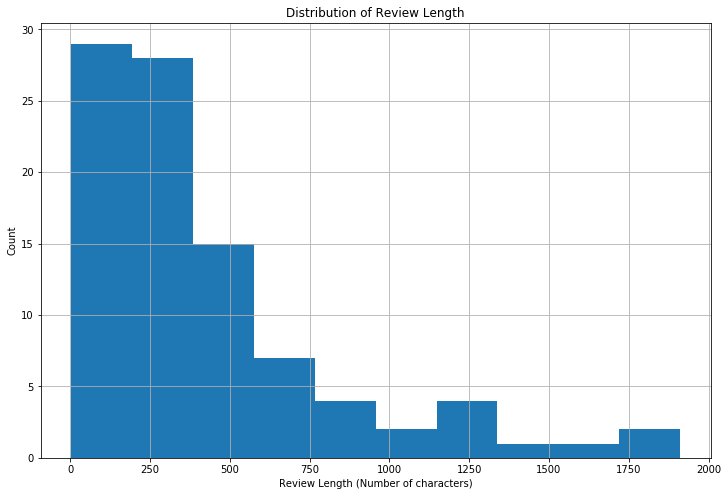

In [7]:
#Data visualization
#Plot distribution of rating
plt.figure(figsize=(12,8))
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Rating")
plt.xlabel("Rating")
plt.ylabel("Count")

#Plot distribution of review length
review_length = df['Body'].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 2000].hist()
plt.title("Distribution of Review Length")
plt.xlabel("Review Length (Number of characters)")
plt.ylabel("Count")

In [8]:
#Prepare data
#Drop missing values
df.dropna(inplace=True)
#Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]
#Encode >3 rating (positive sentiment) and <3 rating as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df['Sentiment'] = df['Sentiment'].convert_objects(convert_numeric=True) #convert sentiment column to float value
df.head()

/Users/tanvirniaz/Documents/Python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/tanvirniaz/Documents/Python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Users/tanvirniaz/Documents/Python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Rating,Title,Date,Verified Purchase,Body,Helpful Votes,Sentiment
2,4.0,"Amazing experience, hard to complain about any...","July 2, 2017",Yes,It's hard not to be impressed with these VR un...,3,1
5,5.0,Everyone will be doing this for hours of enter...,"April 26, 2017",Yes,I have nothing but good to say about the Rift....,11,1
6,4.0,Great first generation VR,"June 3, 2017",Yes,For a first generation consumer VR product it ...,2,1
7,4.0,The Summer bundle,"July 24, 2017",Yes,Bought these during the $399 sale that include...,1,1
8,5.0,Better than HTC,"October 19, 2017",Yes,Excellent headset for PC gamers/users. Intuiti...,1,1


In [9]:
# Split data into training set and validation 
x_train, x_test, y_train, y_test = train_test_split(df['Body'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d test examples. \n' %(x_train.shape[0],x_test.shape[0]))

Load 81 training examples and 10 test examples. 



In [10]:
#Bag of  Words Model
#Text preprocessing
x_train_cleaned=[]
x_test_cleaned=[]

def cleanText(raw_text): #define function to clean text
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case
    return (" ".join (words))
#clean training and test sets
for d in x_train:
    x_train_cleaned.append(cleanText(d))

for d in x_test:
    x_test_cleaned.append(cleanText(d))


In [12]:
#TfidfVectorizer for tokenization and weighted counting for bag of words
tfidf = TfidfVectorizer(min_df=5) 
x_train_tfidf = tfidf.fit_transform(x_train_cleaned)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) 
print("Show some feature names : \n", tfidf.get_feature_names()[:25])

# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

Number of features : 250 

Show some feature names : 
 ['about', 'actually', 'after', 'all', 'almost', 'already', 'also', 'am', 'amazing', 'an', 'and', 'another', 'any', 'are', 'around', 'as', 'at', 'awesome', 'back', 'be', 'because', 'been', 'before', 'being', 'best']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
#Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['was' 'software' 'working' 'last' 'months' 'on' 'issue' 'took' 'that'
 'out']

Top 10 features with largest coefficients : 
['is' 'vr' 'this' 'games' 'you' 'for' 'are' 'of' 'like' 'the']


In [14]:
#Evaluate on the test set
predictions = lr.predict(tfidf.transform(x_test_cleaned)) #predict values for x test set
def modelEvaluation(predictions): #model metrics function
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))

modelEvaluation(predictions) #evaluate


Accuracy on validation set: 1.0000

Classification report : 
              precision    recall  f1-score   support

          1       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        10



In [18]:
#Wordcloud based on sentiment
def  create_word_cloud (sentiment):
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df[df["Sentiment"]==1]["Body"]
            
        if sentiment == 0:
            df_reviews = df[df["Sentiment"]==0]["Body"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

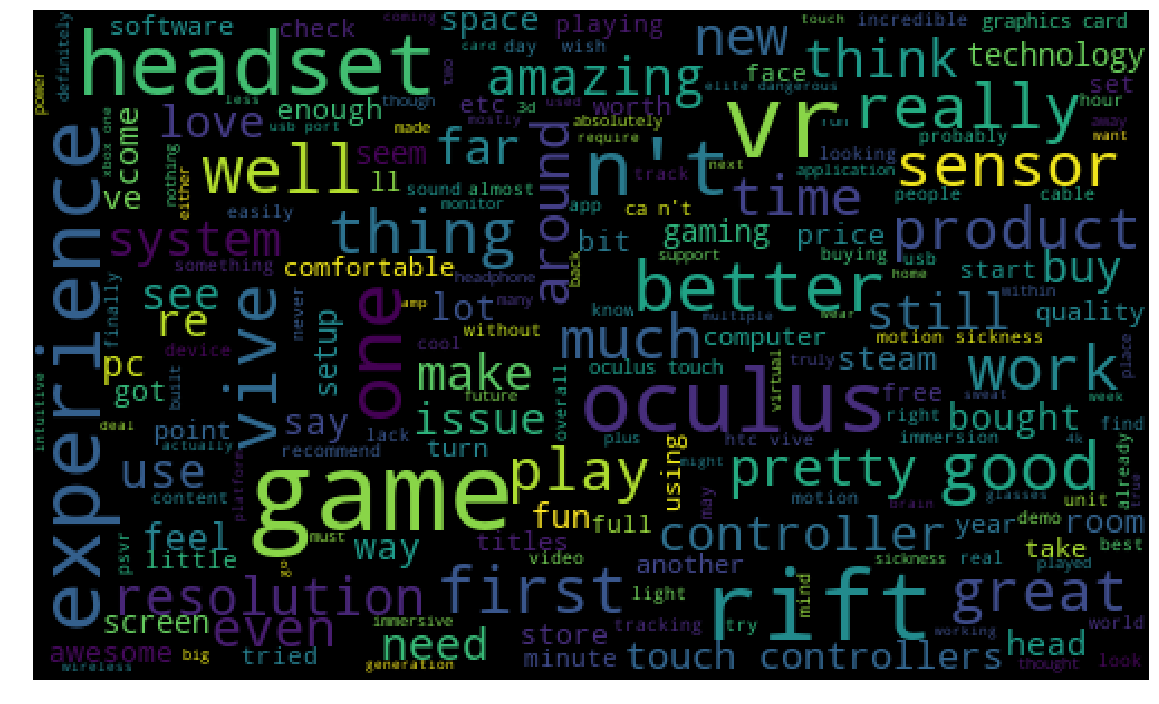

In [19]:
create_word_cloud(sentiment=1) #wordcloud for positive sentiment

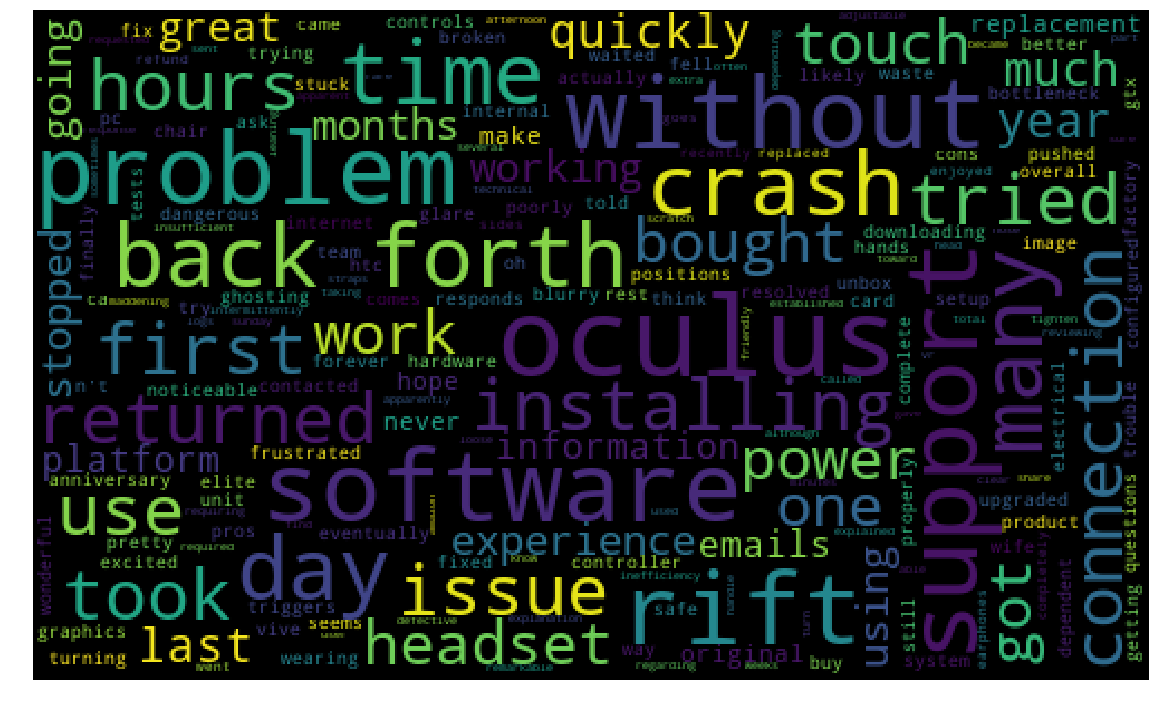

In [20]:
create_word_cloud(sentiment=0) #wordcloud for negative sentiment